In [3]:
import warnings
warnings.filterwarnings('ignore')
import h5py
import numpy as np
import make_animations as m_a
import matplotlib.pyplot as plt
import ffmpeg
import glob
import re

#### 1) Set up simulation parameter values

In [7]:
# domain
Nx, Nz = 4096, 2048
H = -350
L = 1200

# non-dimensional parameters
zeta = 0.093
eta = 8.4
Ri = 29.
chi = 0.41
J = 0.71

# fixed dimensional values
width = 40    # \sigma parameter of the versoria function to define ice keel [m]
U0 = 0.1              # The steady component of the flow in m/s
k0 = 0.5*np.pi/width     # wavenumber of the ice keel (relating sinusoidal and versoria functions) [1/m]

# calculate other parameters based on fixed values and non-dimensional parameters
N = U0*k0/chi         # buoyancy frequency [1/s]
deltaB = Ri*k0*(U0**2) # buoyancy jump across the pycnocline [m/s^2]
h0 = np.pi*zeta/k0       # ice keel height [m]
z0 = -eta*h0          # mixed layer depth [m]

#### 2) Load the file and plot last timestep

In [11]:
# Load the file
filename = 'cluster2_4096_2048.jld2'

# Extract
#  file: dictionary with data
#  sorted_keys: to access the correct timestep in the timeseries
#  x_array: array of x-coordinate values
#  z_array: array of z-coordinate values
#  bh_array: location of the immersed boundary (keel/topography)
#  Z_masked: grid masking due to ice keel/topography
#  time_array: array of time values at each timestep
file, sorted_keys, x_array, z_array, bh_array, Z_masked, time_array = m_a.load_file(filename, Nx, Nz)

In [13]:
# initial buoyancy profile
mu = 0.5
N2 = N**2
b0 = 0.5*(deltaB - N2 * ((H-z0)-z_array)) *(1-np.tanh(((H-z0)-z_array)/mu))

In [31]:
# Calculate total volume of each grid cell
cell_vol, tot_vol = m_a.calc_cell_vol(x_array, z_array, Nx, Nz, Z_masked)

# Find depth array cut-off points
z1 = z_array.min()-z_array
indz_pyc = np.where(z1<z0)[0][0] # cutoff for above pycnocline
indz_keel = np.where(z1<-h0/3)[0][0] #cutoff for above the keel depth
indz_sponge = np.where(z1>-300)[0][-1] #cutoff for below the sponge layer
ind_z0_plus10 = np.where(z1>z0+10)[0][-1] #cutoff 10m above the pycnocline
ind_z0_minus10 = np.where(z1>z0-10)[0][-1] #cutoff 10m below the pycnocline

# Find cutoff points in x for integrating over [-200, 200] m region
indx_left = np.where(x_array<-200)[0][-1] # left cutoff
indx_right = np.where(x_array>200)[0][0] # right cutoff

In [17]:
# Apply sponge masking 
sponge_mask = Z_masked*np.nan
sponge_mask[indz_sponge:, :] = 1

In [19]:
# Read last timestep
indt = -1 # timestep index

# Extract total u velocity, w velocity, and N^2 arrays
utot_array, w_array, N2_array = m_a.extract_variables(file, sorted_keys, x_array,
                                                      z_array,  Z_masked, Nx, Nz, U0, indt)

# Extract buoyancy array
b = file['timeseries']['b'][sorted_keys[indt]]
b_array = np.array(b[:]).reshape(Nz+8,Nx+8)
b_array[np.isnan(Z_masked)] = np.nan

# Calculate the deviation from horizontally-averaged values for u and b
ubar = np.nanmean(utot_array, axis=1)
uprime = utot_array*0
for ind in range(len(z_array)):
    uprime[ind, :] = utot_array[ind, :]-ubar[ind]

bbar = np.nanmean(b_array, axis=1)
bprime = b_array*0
for ind in range(len(z_array)):
    bprime[ind, :] = b_array[ind, :]-bbar[ind]

# Calculate dissipation
wz, wx = np.gradient(w_array, z_array, x_array)
uz, ux = np.gradient(utot_array-U0, z_array, x_array)
diss = (1e-3)*(ux**2+uz**2+wx**2+wz**2)

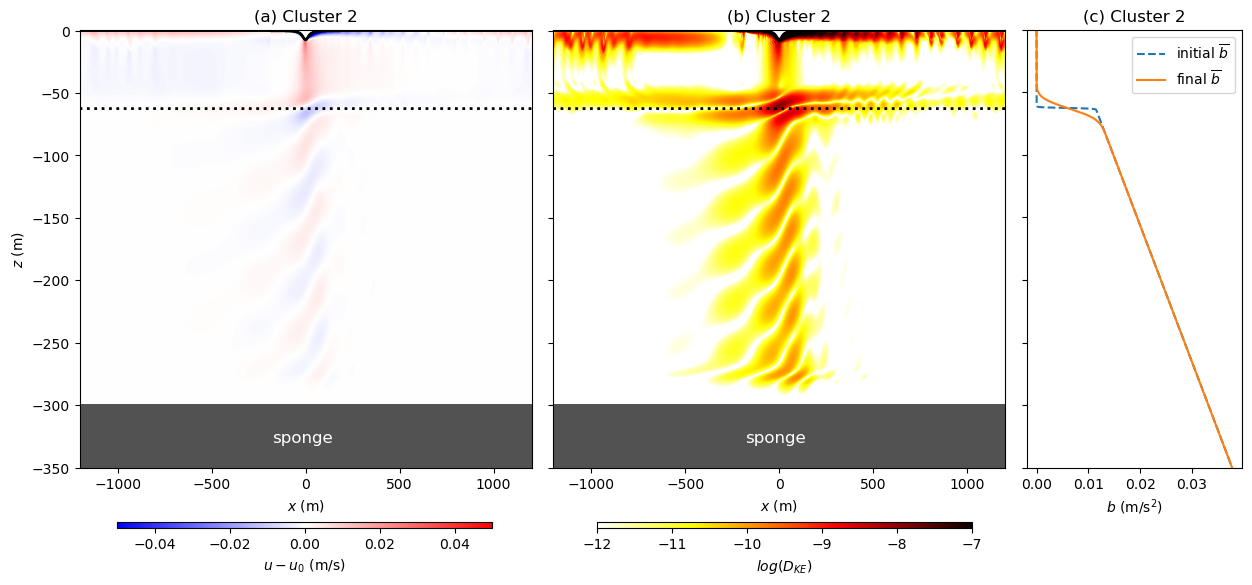

In [21]:
# Make a plot
fig = plt.figure()
gs = fig.add_gridspec(1,5)

ax1 = fig.add_subplot(gs[0:2])
im1 = ax1.pcolor(x_array, H-z_array[:-3], uprime[:-3, :], vmin=-0.05, vmax=0.05, cmap='bwr')
ax1.pcolor(x_array, H-z_array[:-3], sponge_mask[:-3, :], vmin=0, vmax=4, cmap = 'Greys_r')
fig_text = 'sponge'
ax1.text(-180, -330, fig_text, fontsize=12, color='w')
ax1.plot(x_array, H-bh_array, '-k', lw=2.0)
ax1.plot(x_array, z0+0*x_array, ':k', lw=2.0)
ax1.set( ylabel='$z$ (m)', xlabel = '$x$ (m)', title='(a) Cluster 2')

ax2 = fig.add_subplot(gs[2:4])
im2 = ax2.pcolor(x_array, H-z_array[:-3], np.log10(diss[:-3, :]), vmin=-12, vmax=-7, cmap='hot_r')
ax2.pcolor(x_array, H-z_array[:-3], sponge_mask[:-3, :], vmin=0, vmax=4, cmap = 'Greys_r')
ax2.text(-180, -330, fig_text, fontsize=12, color='w')
ax2.plot(x_array, H-bh_array, '-k', lw=2.0)
ax2.plot(x_array, z0+0*x_array, ':k', lw=2.0)
ax2.set(xlabel = '$x$ (m)', title='(b) Cluster 2')
ax2.set_yticklabels([])

ax3 = fig.add_subplot(gs[-1])
ax3.plot(b0[:-3], H-z_array[:-3], '--', label = 'initial $\overline{b}$')
ax3.plot(bbar[:-3], H-z_array[:-3], label = 'final $\overline{b}$')
ax3.set(xlabel = r'$b$ ($\text{m/s}^2$)', title='(c) Cluster 2') 
ax3.legend()
ax3.set_ylim([-350, 0])
ax3.set_yticklabels([])

fig.subplots_adjust(bottom=0.15, wspace=0.1, hspace=0.25)
cbar_ax = fig.add_axes([0.15, 0.05, 0.25, 0.01])
cb = fig.colorbar(im1, cax=cbar_ax, orientation="horizontal", pad=0.2)
cb.set_label('$u-u_0$ (m/s)')

cbar_ax2 = fig.add_axes([0.47, 0.05, 0.25, 0.01])
cb2 = fig.colorbar(im2, cax=cbar_ax2, orientation="horizontal", pad=0.2)
cb2.set_label('$log(D_{KE})$')

fig.set_size_inches(15, 6)

#### 3) Compute region-averaged kinetic energy and kinetic energy dissipation

3 regions: 

- around the pycnocline $[z_0-10, z_0+10]$,
- below the pycnocline $[-300, z_0-10]$,
- above the pycnocline $[z_0+10, h_0/3]$

In [37]:
def calc_var_pyc(Nx, Nz, cell_vol,  u, w, ind_z0_plus10, ind_z0_minus10, indz1, indz2, x_array, z_array):
    KE = 0.5*(u**2 + w**2)
    wz, wx = np.gradient(w, z_array, x_array)
    uz, ux = np.gradient(u, z_array, x_array)
    diss = (1e-3)*(ux**2+uz**2+wx**2+wz**2)
    
    ke_pyc =  np.nansum(cell_vol[ind_z0_plus10:ind_z0_minus10, indx_left:indx_right]*KE[ind_z0_plus10:ind_z0_minus10, indx_left:indx_right])
    diss_pyc = np.nansum(cell_vol[ind_z0_plus10:ind_z0_minus10, indx_left:indx_right]*diss[ind_z0_plus10:ind_z0_minus10, indx_left:indx_right])

    ke_below_pyc =  np.nansum(cell_vol[ind_z0_minus10:indz_sponge, indx_left:indx_right]*KE[ind_z0_minus10:indz2, indx_left:indx_right])
    diss_below_pyc = np.nansum(cell_vol[ind_z0_minus10:indz_sponge, indx_left:indx_right]*diss[ind_z0_minus10:indz2, indx_left:indx_right])

    ke_above_pyc =  np.nansum(cell_vol[indz_keel:ind_z0_plus10, indx_left:indx_right]*KE[indz1:ind_z0_plus10, indx_left:indx_right])
    diss_above_pyc = np.nansum(cell_vol[indz_keel:ind_z0_plus10, indx_left:indx_right]*diss[indz1:ind_z0_plus10, indx_left:indx_right])

    
    vol_pyc = np.nansum(cell_vol[ind_z0_plus10:ind_z0_minus10, indx_left:indx_right])
    vol_below_pyc = np.nansum(cell_vol[ind_z0_minus10:indz_sponge, indx_left:indx_right])
    vol_above_pyc = np.nansum(cell_vol[indz_keel:ind_z0_plus10, indx_left:indx_right])
    
    return ke_pyc, diss_pyc, ke_below_pyc, diss_below_pyc, ke_above_pyc, diss_above_pyc, vol_pyc, vol_below_pyc, vol_above_pyc

In [39]:
# Calculate timeseries for region-averaged kinetic energy and kinetic energy dissipation in the three regions

ke_pyc_cluster = 0*time_array
diss_pyc_cluster = 0*time_array
ke_below_pyc_cluster = 0*time_array
diss_below_pyc_cluster = 0*time_array
ke_above_pyc_cluster = 0*time_array
diss_above_pyc_cluster = 0*time_array

for ind in range(len(time_array)):
    utot_array, w_array, N2_array = m_a.extract_variables(file, sorted_keys, x_array,
                                                      z_array,  Z_masked, Nx, Nz, U0, ind)
    ubar = np.nanmean(utot_array, axis=1)
    uprime = utot_array*0
    for i in range(len(z_array)):
        uprime[i, :] = utot_array[i, :]-ubar[i]
    #cm, ke  = calc_cm(Nx, Nz, x_array, z_array, utot_array-U0, w_array)
    k1, d1, k2, d2, k3, d3, v1, v2, v3 = calc_var_pyc(Nx, Nz, cell_vol,  uprime, w_array, 
                                                      ind_z0_plus10, ind_z0_minus10, indz_keel, indz_sponge, x_array, z_array)
    ke_pyc_cluster[ind] = k1
    diss_pyc_cluster[ind] = d1
    ke_below_pyc_cluster[ind] = k2
    diss_below_pyc_cluster[ind] = d2
    ke_above_pyc_cluster[ind] = k3
    diss_above_pyc_cluster[ind] = d3

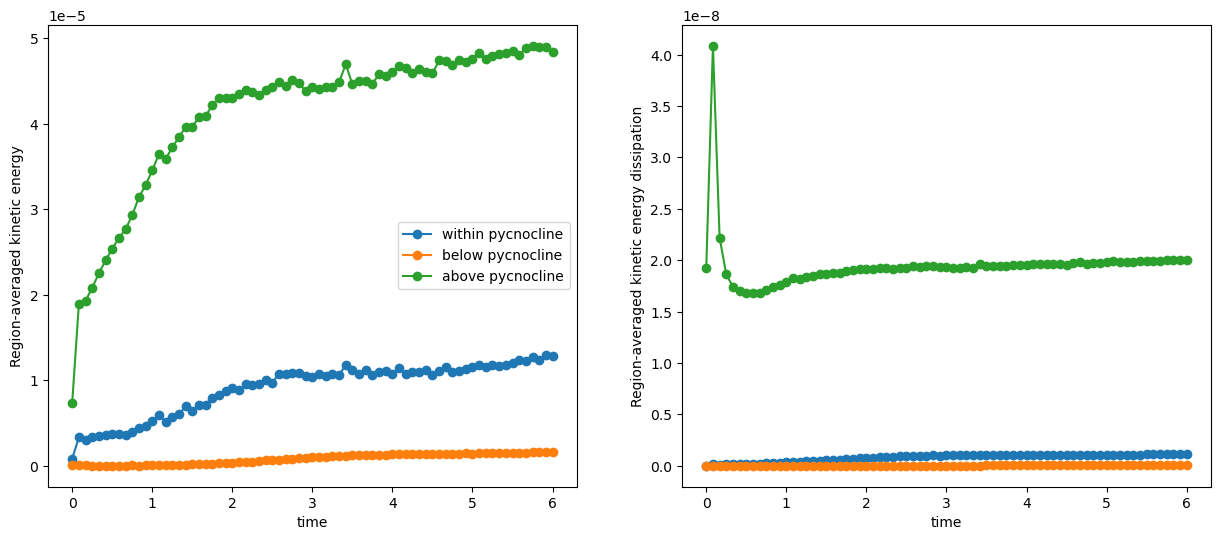

In [40]:
fig, ax = plt.subplots(1,2)
ax[0].plot(time_array/60, ke_pyc_cluster/v1, '-o', label='within pycnocline')
ax[0].plot(time_array/60, ke_below_pyc_cluster/v2, '-o', label='below pycnocline')
ax[0].plot(time_array/60, ke_above_pyc_cluster/v3, '-o', label='above pycnocline')
ax[0].set(ylabel = 'Region-averaged kinetic energy', xlabel='time')
ax[0].legend()

ax[1].plot(time_array/60, diss_pyc_cluster/v1, '-o')
ax[1].plot(time_array/60, diss_below_pyc_cluster/v2, '-o')
ax[1].plot(time_array/60, diss_above_pyc_cluster/v3, '-o')
ax[1].set(ylabel = 'Region-averaged kinetic energy dissipation', xlabel='time')
fig.set_size_inches(15,6)